# Changing Parameters of the Taxes and Transfers System

This tutorial focuses on the `policy_params` of GETTSIM, one of the two objects returned by the function `set_up_policy_environment`. It is a dictionary that contains all the date-specific parameters (e.g. level of unemployment benefit) that are necessary to compute the target variables we are interested in. GETTSIM not only provides current and past policy environments, but also allows users to alter policies for instance by changing parameters.

In [1]:
import copy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from gettsim import set_up_policy_environment
from gettsim import compute_taxes_and_transfers

## Example: Special Child Bonus from 2020

In this tutorial, we will implement such a policy change using the example of an actual child bonus policy implemented in 2020. For this policy, the German government pays a special child bonus of 300€ per child to households with children as part of a stimulus package. The households will receive the special child bonus as part of the *Kindergeld* which is an established part of the German taxes and transfers system.

*Small Recap: Kindergeld is a child benefit that can be claimed by parents in Germany. Mainly lower-income families benefit from Kindergeld. For higher-income families, the tax credits for children are more advantageous, so that they do not receive Kindergeld. The child benefit and how they are implemented in GETTSIM is explained in more detail in the* [advanced usage tutorial](advanced_usage.ipynb).

To implement the reform in GETTSIM, we will change relevant parameters in the existing system by editing the policy parameters that shape the policy environment.

## Finding the relevant parameter

Firstly, we can load the existing policy environment for the year 2020 using the function `set_up_policy_environment`.

In [2]:
policy_params, policy_functions = set_up_policy_environment("2020")

We can open the dictionary with all the parameters by typing `policy_params`. The parameters are saved to a nested dictionary, meaning that the dictionary consists of multiple further dictionaries. This can make displaying the parameter values look confusing at first sight.

To get an idea of the structure of the dictionary, we will work us through it step by step. First we take a look at the `keys` of the `dict`. The first layer of keys represent different policy groups.

In [3]:
print(*policy_params.keys(), sep="\n")

eink_st
eink_st_abzuege
soli_st
arbeitsl_geld_2
arbeitsl_geld
soz_vers_beitr
unterhalt
abgelt_st
wohngeld
kinderzuschlag
kindergeld
elterngeld


Since we are interested in altering child benefits, we will select the key "kindergeld" to inspect the according parameters further. The parameters are saved to a sub-dictionary which can be selected using `policy_params["kindergeld"]`. It contains the keys to different parameter groups that affect child benefits in the German system:

In [4]:
print(*policy_params["kindergeld"].keys(), sep="\n")

kindergeld_hoechstalter
kindergeld
kindergeld_einkommensgrenze
kindergeld_stundengrenze
datum


- **kindergeld_hoechstalter** is the maximum age of a child that is entitled to *Kindergeld*.

- **kindergeld** is the amount of money that parents receive for their children.

- **kindergeld_einkommensgrenze** is the maximum annual income of a child that is still entitled to *Kindergeld*.

- **kindergeld_stundengrenze** is the maximum number of weekly working hours of a child that is entitled to *Kindergeld*.

- **datum** specify the date to which the parameters apply in the German taxes and transfers system. 

The reform we are simulating influences the amount of money that parents receive for their children. Let´s take a look at the value of this parameter:

In [5]:
policy_params["kindergeld"]["kindergeld"]

{1: 204, 2: 204, 3: 210, 4: 235}

For the first and second child, the monthly *Kindergeld* is 204€. For the third child, monthly *Kindergeld* is 210€. For each additional child, *Kindergeld* is 235€.

## Changing the parameter

To implement the reform, we create a new parameter dictionary by creating a copy of the original which we can then alter.

In [6]:
policy_params_reformed = copy.deepcopy(policy_params)

Using a loop, we add the 300€ to each entry of our new `policy_params_reformed["kindergeld"]["kindergeld"]`. As the parameter is defined on a monthly level, we divide 300€ by 12. (In reality, the special child bonus will be paid in two seperate payments of 200€ and 100€ in the fall of 2020.)

In [7]:
# Loop through policy paramaters to add the special child bonus.
for n in policy_params_reformed["kindergeld"]["kindergeld"]:
    policy_params_reformed["kindergeld"]["kindergeld"][n] += 300 / 12

Now we can check if the ```params_dict_reformed``` shows different values for the ```["kindergeld"]["kindergeld"]``` entries:

In [8]:
policy_params_reformed["kindergeld"]["kindergeld"] 

{1: 229.0, 2: 229.0, 3: 235.0, 4: 260.0}

It worked, we raised all values by 300/12.

------


**Remark**: In the same way, we can also add new parameters to the `policy_params`, e.g. we could implement the special child bonus as a separate parameter:

In [9]:
policy_params_reformed["kindergeld"]["kinderbonus"] = 300 / 12

Of course this is only useful if we edit the `policy_functions` as well. Otherwise the new parameter will not be taken into account by any function. Check out the [policy functions tutorial](policy_functions.ipynb) for more information on changing or adding policy functions to a policy environment in GETTSIM.

------

## Applying the edited parameter dictionary to simulated households

We can use the simulated data from the [advanced usage tutorial](advanced_usage.ipynb) to illustrate the the impact of the reform we implemented above. For simplicity, we will only look at households with two children and two parents. 

In [10]:
# Load data from .csv-file.
data = pd.read_csv("household_data_kindergeld.csv")
# Filter data to include only households with 2 children.
data = data[data.anz_minderj_hh == 2]
data.head()

,p_id,hh_id,tu_id,bruttolohn_m,vermögen_hh,prv_krankenv,alter,hat_kinder,kind,anz_minderj_hh,...,vermiet_eink_m,kapital_eink_m,prv_rente_beitr_m,wohnort_ost,jahr_renteneintr,betreuungskost_m,in_ausbildung,behinderungsgrad,arbeitsstunden_w,alleinerziehend
655,2000,2000,2000,1500.0,0,False,50,True,False,2,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
656,2001,2000,2000,1500.0,0,False,50,True,False,2,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False
657,2002,2000,2000,NaN,0,False,10,False,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
658,2003,2000,2000,NaN,0,False,5,False,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
659,2004,2001,2001,1550.0,0,False,50,True,False,2,...,0.0,0.0,0.0,False,2100.0,0.0,False,0.0,40.0,False


This simulated data set shows 130 households with each two  50 year old parents and their 5 & 10 year old children. The households/tax units only vary in their income.

First, we compute the *Kindergeld* with the original parameters:

In [11]:
result_no_reform = compute_taxes_and_transfers(
    data = data,
    params=policy_params,
    functions=policy_functions,
    targets="kindergeld_m_tu",
    )

result_no_reform

,kindergeld_m_tu
655,408
656,408
657,408
658,408
659,408
...,...
1174,0
1175,0
1176,0
1177,0


Now we do exactly the same, but using the `policy_params_reformed`.

In [12]:
result_reform = compute_taxes_and_transfers(
    data = data,
    functions=policy_functions,
    params=policy_params_reformed,
    targets="kindergeld_m_tu"
    )
result_reform

,kindergeld_m_tu
655,458.0
656,458.0
657,458.0
658,458.0
659,458.0
...,...
1174,0.0
1175,0.0
1176,0.0
1177,0.0


## Visualization / Further Analysis

Our results so far offer a good starting point to analyze the reform in further detail, though this would lead away from the introduction into GETTSIM. Still, we can easily visualize and compare the amount of *Kindergeld* in the two different scenarios.

Therefore, we reorganize our data. We create a pandas.DataFrame with the total monthly income of each tax unit and the *Kindergeld* they receive with the `policy_params_reformed` and the `policy_params`:

In [13]:
# Group data by tax unit id and sum the gross monthly income.
total_income_tu = data.groupby("tu_id")["bruttolohn_m"].sum()
total_income_tu

tu_id
2000     3000.0
2001     3100.0
2002     3200.0
2003     3300.0
2004     3400.0
         ...   
2126    15600.0
2127    15700.0
2128    15800.0
2129    15900.0
2130    16000.0
Name: bruttolohn_m, Length: 131, dtype: float64

In [14]:
# Create DataFrame with relevant columns for plotting.
data_plot = pd.DataFrame() 
data_plot["Kindergeld no reform"] = result_no_reform["kindergeld_m_tu"]
data_plot["Kindergeld reformed"] = result_reform["kindergeld_m_tu"]
data_plot["tu_id"] = data["tu_id"]
data_plot = data_plot.drop_duplicates("tu_id").set_index("tu_id")
data_plot["income"] = total_income_tu

We can illustrate the effect of the special child bonus of 2020 by plotting the *Kindergeld* of the two scenarios:

<AxesSubplot:xlabel='income'>

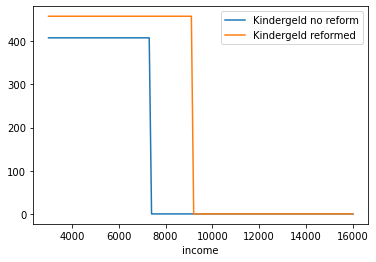

In [15]:
data_plot.plot(x="income", y=["Kindergeld no reform", "Kindergeld reformed"])

Unsurprisingly, the special child bonus increases the amount of money that tax units receive if they are entitled to *Kindergeld*. At the same time, more tax units are entitled to *Kindergeld* as the threshold at which tax allowances become more advantageous moves up.

Of course this is a *very* basic visualization and analysis. If we take into account basic social security (e.g. unemployment benefit) our approach would lead to wrong results. Usually *Kindergeld* is considered as income, so that social security payments are lowered by the amount of the received *Kindergeld*. In contrast, in the case of the special child bonus, recipients of social security payments receive the special child bonus on top of other payments. 

For a correct simulation of these effects it would be necessary to additionally change the `policy_functions`. You can take a look at [this](https://gettsim.readthedocs.io/en/latest/tutorials/policy_functions.html) tutorial to learn more about the `policy_functions`.